# かがわAIゼミナール2019
## 課題１ : kickstarter-projects
## クラウドファンデイングが成功するか(state)を予測

#### DATA:kaggle   https://www.kaggle.com/kemical/kickstarter-projects
#### 注意点）　説明変数は現時点でわかっている情報だけを使用すること

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import log_loss, accuracy_score, precision_recall_fscore_support, confusion_matrix
from datetime import datetime
from datetime import date

In [2]:
# データ読み込み
df_data_csv = pd.read_csv("./kickstarter-projects/ks-projects-201801.csv") 
display(df_data_csv.head())

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


項目
- ID
- name
- category
- main_category
- currency : 通貨
- deadline : 締め切り日
- goal : Goal amount in project currency : プロジェクト通過での目標額
- launched : 開始日時
- pledged : Pledged amount in the project currency : プロジェクト通貨での元本額
- state : 状態
- backers : 支援者数
- country : 国
- usd pledged : Pledged amount in USD (conversion made by KS) : 担保金額（米ドル）（KSによる変換）
- usd_pledged_real : Pledged amount in USD (conversion made by fixer.io api) : 担保金額（米ドル）
- usd_goal_real : Goal amount in USD : 目標額（米ドル）

（プロジェクトスタート時に取得できない情報、backers と pledged　→　使用しない）

In [3]:
# 行列数確認
print(df_data_csv.shape)

(378661, 15)


In [4]:
# 統計量表示
df_data_csv.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


In [5]:
# 欠損値がないか確認
print(df_data_csv.isnull().sum())

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


まずは、今回の目標である「成功するかしないか」の二値分類にするため、目的変数stateを（成功'successful' : 1, その他：0） 置き換える

In [6]:
# クラウドファウンディングが成功：１、失敗：０に変換
df_data = df_data_csv
df_data['state'] = np.where(df_data['state'] == "successful", 1, 0)

使えそうな説明変数をピックアップ
- category
- main_category
- state
- country
- usd_goal_real
- day_diff : 資金を集められる期間( = deadline - launched)

In [7]:
# 資金を集められる期間（開始日と締め切り日の差(day_diff)）が関係ありそうなので表に追加
# 文字列データをdatetimeに変換
df_data['deadline'] = df_data['deadline'].apply(lambda x:datetime.strptime(x[:10], "%Y-%m-%d"))
df_data['launched'] = df_data['launched'].apply(lambda x:datetime.strptime(x[:10], "%Y-%m-%d"))
# 日数の差
day_diff = (df_data['deadline'] - df_data['launched']).apply(lambda x: x.days)
# カラム追加
df_data['day_diff'] = day_diff

In [8]:
# 使用するカラムを選択
df_data = df_data[['category','main_category', 'state', 'country', 'usd_goal_real', 'day_diff']]
df_data.head()

,category,main_category,state,country,usd_goal_real,day_diff
0,Poetry,Publishing,0,GB,1533.95,59
1,Narrative Film,Film & Video,0,US,30000.00,60
2,Narrative Film,Film & Video,0,US,45000.00,45
3,Music,Music,0,US,5000.00,30
4,Film & Video,Film & Video,0,US,19500.00,56


### データの整理（前処理）

- 欠損値Nanチェック
- 外れ値チェック
- カテゴリ変数をダミー変数に変換　category, main_category, country
- カテゴリはメインカテゴリを使うか詳細なカテゴリを使うか
- データ数が37万件と多いため、ランダムにサンプリングする

In [9]:
# 欠損値がないか確認
print(df_data.isnull().sum())

category         0
main_category    0
state            0
country          0
usd_goal_real    0
day_diff         0
dtype: int64


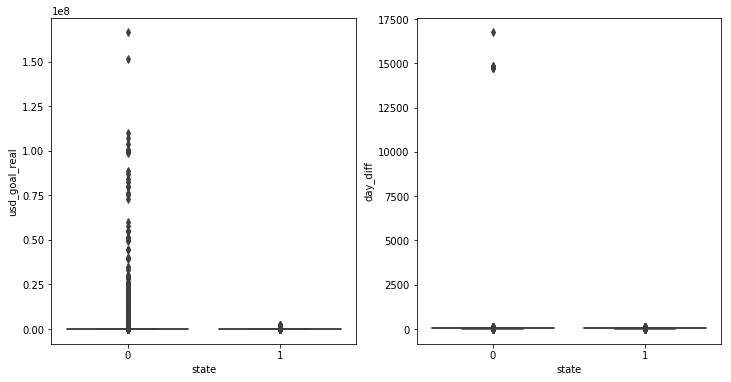

In [10]:
# 外れ値がないか確認
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(x='state', y='usd_goal_real',  data=df_data, ax=ax[0])
sns.boxplot(x='state', y='day_diff',  data=df_data, ax=ax[1])

箱ひげ図より外れ値が大きいことがわかるので、usd_goal_realとday_diffの外れ値を除く

In [11]:
# 外れ値を除く
df_data = df_data[df_data['usd_goal_real'] < 100000]
df_data = df_data[df_data['day_diff'] < 1000]

In [12]:
df_data.shape

(362490, 6)

In [13]:
# 統計量表示
df_data.describe()

,state,usd_goal_real,day_diff
count,362490.000000,362490.000000,362490.000000
mean,0.366076,11585.232364,33.975903
std,0.481731,15936.502211,12.722431
min,0.000000,0.010000,1.000000
25%,0.000000,2000.000000,30.000000
50%,0.000000,5000.000000,30.000000
75%,1.000000,15000.000000,36.000000
max,1.000000,99999.990000,92.000000


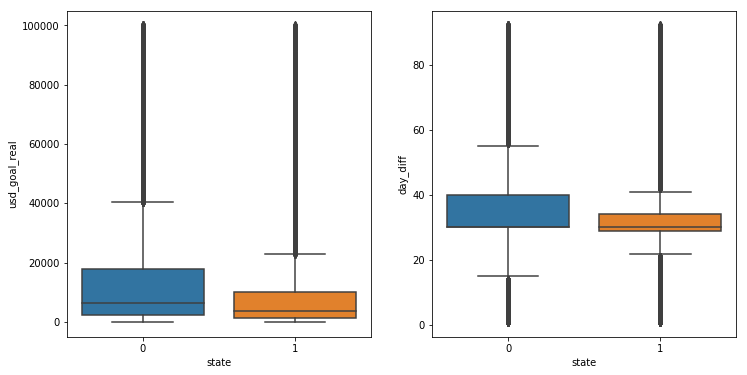

In [14]:
# 外れ値がないか確認
fig, ax = plt.subplots(1,2,figsize=(12,6))
sns.boxplot(x='state', y='usd_goal_real',  data=df_data, ax=ax[0])
sns.boxplot(x='state', y='day_diff',  data=df_data, ax=ax[1])

In [15]:
# カテゴリーについて、メインカテゴリを使うか詳細なカテゴリを使うか
print(df_data['category'].value_counts())
# 159種
print(df_data['main_category'].value_counts())
# 15種
#  →　種類の少ないmain_categoryを使用してみる

Product Design       21134
Music                15464
Documentary          15245
Tabletop Games       13995
Shorts               12282
Food                 11027
Video Games          10510
Film & Video          9228
Fiction               9103
Fashion               8397
Nonfiction            8205
Art                   8072
Apparel               7017
Theater               6948
Children's Books      6724
Rock                  6707
Publishing            5867
Technology            5809
Photography           5709
Apps                  5658
Indie Rock            5641
Webseries             5581
Comics                4962
Narrative Film        4704
Web                   4662
Crafts                4606
Country & Folk        4431
Design                3995
Hip-Hop               3824
Pop                   3311
                     ...  
Couture                260
Animals                248
Civic Design           246
Printing               237
Puzzles                228
Makerspaces            219
S

In [16]:
# カテゴリ変数をダミー変数に変換（One-Hotベクトル）

# category
df_data = pd.concat([df_data, pd.get_dummies(df_data['main_category'])], axis=1)
df_data = df_data.drop(['category','main_category'], axis=1)
df_data.head()

,state,country,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,Food,Games,Journalism,Music,Photography,Publishing,Technology,Theater
0,0,GB,1533.95,59,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,US,30000.00,60,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,US,45000.00,45,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,US,5000.00,30,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,US,19500.00,56,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [17]:
# country
df_data = pd.concat([df_data, pd.get_dummies(df_data['country'])], axis=1)
df_data = df_data.drop(['country'], axis=1)
df_data.head()

,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
0,0,1533.95,59,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,30000.00,60,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,45000.00,45,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,0,5000.00,30,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,19500.00,56,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [18]:
# サンプルデータをランダムに１万件取得　
df_data_a = df_data.sample(n=10000, random_state=123)
df_data_a.head()

,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
200784,1,20000.00,30,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
261910,0,10000.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
316094,0,5500.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
147285,1,20000.00,60,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
266287,0,6212.09,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
df_data_a.describe()

,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,JP,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,...,10000.0,10000.0000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000
mean,0.36820,11573.329080,34.107600,0.075700,0.032400,0.024100,0.011500,0.079900,0.05840,0.159800,...,0.0,0.0001,0.006000,0.009600,0.006800,0.002200,0.002800,0.004100,0.00160,0.778900
std,0.48234,15914.496327,12.755269,0.264531,0.177069,0.153367,0.106625,0.271152,0.23451,0.366439,...,0.0,0.0100,0.077231,0.097513,0.082185,0.046855,0.052844,0.063903,0.03997,0.415008
min,0.00000,0.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
25%,0.00000,2000.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
50%,0.00000,5000.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
75%,1.00000,15000.000000,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,...,0.0,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000
max,1.00000,99000.000000,92.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,...,0.0,1.0000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000


In [20]:
# 説明変数"JP"のデータが全て0になっているので、除く
df_data_a = df_data_a.drop('JP', axis=1)
df_data_a.head()

,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,IT,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
200784,1,20000.00,30,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
261910,0,10000.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
316094,0,5500.00,34,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
147285,1,20000.00,60,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
266287,0,6212.09,27,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
# 相関係数を確認
df_data_a.corr()

,state,usd_goal_real,day_diff,Art,Comics,Crafts,Dance,Design,Fashion,Film & Video,...,IT,LU,MX,"N,0""",NL,NO,NZ,SE,SG,US
state,1.000000,-0.183075,-0.110004,0.018241,0.082792,-0.044257,0.057671,-0.010852,-0.059264,0.012231,...,-0.032453,-0.007634,-0.027094,-0.066654,-0.040461,-0.022570,0.006633,-0.000312,0.000564,0.073988
usd_goal_real,-0.183075,1.000000,0.117963,-0.088540,-0.046544,-0.035433,-0.022398,0.095835,0.000784,0.028244,...,0.026392,-0.000169,-0.017554,-0.039939,0.013291,0.002979,-0.007621,-0.008726,-0.006149,-0.033450
day_diff,-0.110004,0.117963,1.000000,-0.036441,0.003371,-0.017532,0.001443,0.007779,-0.020657,0.032589,...,0.027767,-0.014198,0.029598,-0.020369,-0.013387,0.016840,-0.008311,-0.000296,-0.010342,0.040712
Art,0.018241,-0.088540,-0.036441,1.000000,-0.052368,-0.044973,-0.030868,-0.084333,-0.071271,-0.124807,...,-0.006190,-0.002862,-0.007549,-0.028176,-0.005279,-0.005369,0.006299,-0.000614,-0.011456,0.017648
Comics,0.082792,-0.046544,0.003371,-0.052368,1.000000,-0.028756,-0.019737,-0.053924,-0.045572,-0.079803,...,-0.015474,-0.001830,0.000410,-0.018016,-0.015141,0.003462,0.000992,0.005936,0.006805,0.010393
Crafts,-0.044257,-0.035433,-0.017532,-0.044973,-0.028756,1.000000,-0.016950,-0.046309,-0.039136,-0.068533,...,-0.013289,-0.001572,0.038451,-0.015472,-0.005069,0.020456,-0.008327,0.000121,0.010024,0.002019
Dance,0.057671,-0.022398,0.001443,-0.030868,-0.019737,-0.016950,1.000000,-0.031785,-0.026862,-0.047039,...,-0.009121,-0.001079,0.003765,-0.010619,0.002488,-0.005065,-0.005715,-0.006921,-0.004318,0.023565
Design,-0.010852,0.095835,0.007779,-0.084333,-0.053924,-0.046309,-0.031785,1.000000,-0.073389,-0.128515,...,0.036578,-0.002947,-0.003792,-0.029013,0.011519,-0.005965,0.005324,-0.007364,0.043570,-0.039408
Fashion,-0.059264,0.000784,-0.020657,-0.071271,-0.045572,-0.039136,-0.026862,-0.073389,1.000000,-0.108610,...,0.004335,-0.002491,-0.019349,-0.020146,-0.010229,0.006510,0.011014,-0.015979,0.022039,-0.018371
Film & Video,0.012231,0.028244,0.032589,-0.124807,-0.079803,-0.068533,-0.047039,-0.128515,-0.108610,1.000000,...,-0.014126,-0.004361,0.008524,0.032632,-0.016161,-0.008828,-0.002450,-0.010899,-0.017458,0.046243


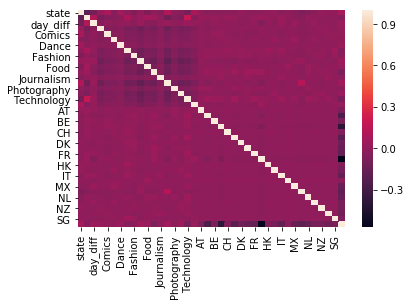

In [22]:
# 相関係数をヒートマップにして可視化
sns.heatmap(df_data_a.corr())
plt.show()

## ロジスティック回帰を使って学習

In [23]:
y = df_data_a.loc[:,['state']].values
X_temp = df_data_a.drop('state', axis=1)
X = X_temp.values
# ロジスティック回帰
clf = SGDClassifier(loss='log', penalty='none', max_iter=10000, fit_intercept=True, random_state=123)
clf.fit(X, y)

/Users/giraffe/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', max_iter=10000, n_iter=None,
       n_jobs=1, penalty='none', power_t=0.5, random_state=123,
       shuffle=True, tol=None, verbose=0, warm_start=False)

In [24]:
# ラベルを予測
y_pred = clf.predict(X)

In [25]:
# 対数尤度を表示
print('対数尤度 = {:.3f}'.format(- log_loss(y, y_pred)))

# 正答率を表示
print('正答率（Accuracy） = {:.3f}%'.format(100 * accuracy_score(y, y_pred)))

# Precision, Recall, F1-scoreを計算
precision, recall, f1_score, _ = precision_recall_fscore_support(y, y_pred)

# Precision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3f}%'.format(100 * precision[0]))
print('再現率（Recall） = {:.3f}%'.format(100 * recall[0]))
print('F1値（F1-score） = {:.3f}%'.format(100 * f1_score[0]))

対数尤度 = -12.614
正答率（Accuracy） = 63.480%
適合率（Precision） = 63.754%
再現率（Recall） = 97.800%
F1値（F1-score） = 77.189%


In [26]:
# 予測値と正解のクロス集計
conf_mat = pd.DataFrame(confusion_matrix(y, y_pred, labels=[0,1]), 
                        index=['正解 = 成功', '正解 = 失敗'], 
                        columns=['予測 = 成功', '予測 = 失敗'])
conf_mat

,予測 = 成功,予測 = 失敗
正解 = 成功,6179,139
正解 = 失敗,3513,169


### Day1課題の結果、成功と多く予測してしまいRecallが高くなってしまった。全体的にもAcuuracyも低い。